# Violinplot over antal dage i cirkulation

In [26]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

In [27]:
# Find alle Excel-filer i en mappe
filer = glob.glob("/Users/mathias/Desktop/Uni/4. Semester/Dataprojekt/Rådata/2023 AAR vaskeri data/*.xlsx")

# Indlæs alle filer og saml dem i en liste
dataframes = [pd.read_excel(fil, skiprows=2) for fil in filer]

# Eventuelt kombiner alle til én DataFrame
samlet_df = pd.concat(dataframes, ignore_index=True)

In [28]:
print(samlet_df.head())

                     Produkt - Produkt       Kassationsårsag (ui)  \
0             04290 Skjorte Marine P/B  Misligholdt med restværdi   
1         01085 T-Shirt Gråmelange p/b    Alm.slid uden restværdi   
2    07963 Busseron 1/Indv L/Æ Hvid Pb    Alm.slid uden restværdi   
3  02788 Sweatshirt Mblå Elis Chauffør               Udgået Model   
4  02788 Sweatshirt Mblå Elis Chauffør               Udgået Model   

   Stk. tøj per kassationsdato  Dage i cirkulation  Total antal vask  \
0                            1                6765               118   
1                            1                6303                58   
2                            1                5753                71   
3                            1                5719                 0   
4                            1                5719                34   

  Unik Kode (ui)  
0   00D003F3D627  
1   00D005120D02  
2   00D00588E66D  
3   00D006ABCB5D  
4   00D006ADF27E  


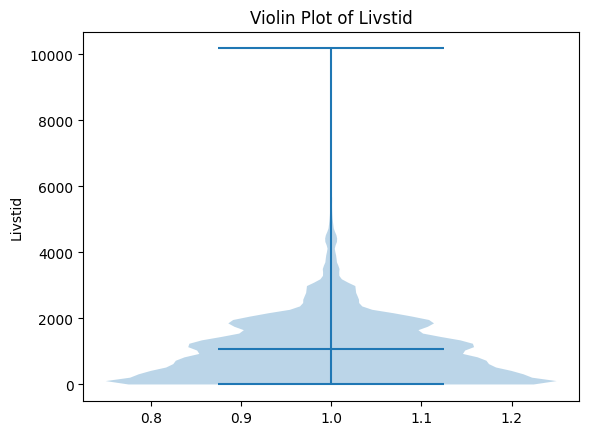

In [29]:
# Lav et violin plot af livstid
livstid = samlet_df['Dage i cirkulation']
plt.violinplot(livstid, showmeans=True)
plt.title('Violin Plot of Livstid')
plt.ylabel('Livstid')
plt.show()

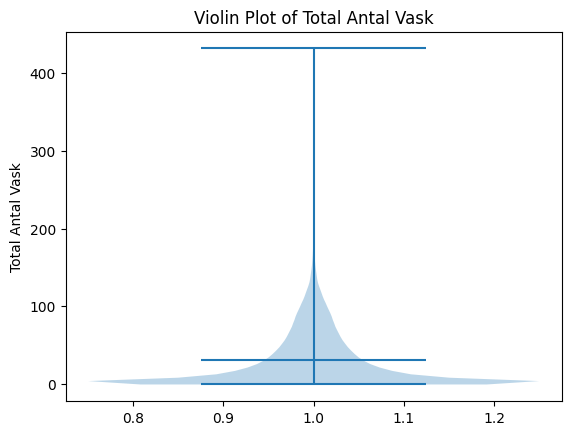

In [32]:
# Lav et violin plot af total_antal_vask
total_antal_vask = samlet_df['Total antal vask']
plt.violinplot(total_antal_vask, showmeans=True)
plt.title('Violin Plot of Total Antal Vask')
plt.ylabel('Total Antal Vask')
plt.show()